In [1]:

# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, nb_utils
except ImportError as e:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.")
    print(e)

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
from libs.datasets import CELEB
files = CELEB()

In [3]:
type(files)

list

In [4]:
len(files)

202599

In [5]:
from libs.dataset_utils import create_input_pipeline
batch_size = 100
n_epochs = 10
input_shape = [218, 178, 3]
crop_shape = [64, 64, 3]
crop_factor = 0.8
batch = create_input_pipeline(
    files =files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor = crop_factor,
    shape=input_shape
    )

In [6]:
sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord= coord)


(100, 64, 64, 3)
float32 255.0


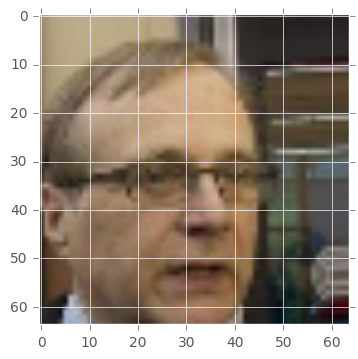

In [7]:
batch_xs = sess.run(batch)
print(batch_xs.shape)
print(batch_xs.dtype, np.max(batch_xs))
plt.imshow(batch_xs[0]/255.0)

In [8]:
import tensorflow as tf
import requests
txt = requests.get('https://www.gutenberg.org/cache/epub/11/pg11.txt').text

In [9]:
txt[:100]

"\ufeffProject Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll\r\n\r\nThis eBook is for the use"

In [10]:
vocab = list(set(txt))
len(txt), len(vocab)

(167516, 86)

In [11]:
encoder = dict(zip(vocab, range(len(vocab))))
decoder = dict(zip(range(len(vocab)), vocab))

In [12]:
decoder

{0: 'u',
 1: 'L',
 2: 'C',
 3: 'I',
 4: '$',
 5: 'd',
 6: '0',
 7: 'Q',
 8: 'D',
 9: 'H',
 10: '5',
 11: 'Y',
 12: 'U',
 13: 'V',
 14: '8',
 15: '#',
 16: 's',
 17: 'o',
 18: 'S',
 19: 'M',
 20: 'h',
 21: 'T',
 22: ')',
 23: '?',
 24: '6',
 25: '"',
 26: 'p',
 27: ']',
 28: ',',
 29: 'k',
 30: 'e',
 31: '%',
 32: 'K',
 33: 'n',
 34: 'c',
 35: '9',
 36: 'O',
 37: '*',
 38: 'z',
 39: 'g',
 40: '-',
 41: '[',
 42: 'y',
 43: '\ufeff',
 44: '(',
 45: 'f',
 46: '\r',
 47: 'q',
 48: 'J',
 49: 'E',
 50: 'G',
 51: 'w',
 52: ' ',
 53: 'l',
 54: '4',
 55: '!',
 56: 'b',
 57: 'Z',
 58: 'i',
 59: 'j',
 60: 'B',
 61: 'W',
 62: '@',
 63: 'v',
 64: 'a',
 65: '3',
 66: ':',
 67: '2',
 68: 'F',
 69: '/',
 70: '\n',
 71: 'r',
 72: 'P',
 73: 'm',
 74: 'X',
 75: '7',
 76: '.',
 77: 'N',
 78: 't',
 79: 'x',
 80: 'A',
 81: '1',
 82: "'",
 83: ';',
 84: 'R',
 85: '_'}

Create the Model

In [13]:
batch_size = 100
sequence_length = 100
n_cells = 256
n_layers = 2
n_chars = len(vocab)

In [14]:
X = tf.placeholder(tf.int32, [None, sequence_length], name='X')
Y = tf.placeholder(tf.int32, [None, sequence_length], name='Y')

In [15]:
embedding = tf.get_variable("embedding", [n_chars, n_cells])
Xs = tf.nn.embedding_lookup(embedding, X)
print(Xs.get_shape().as_list())

[None, 100, 256]


In [16]:
with tf.name_scope('reslice'):
    Xs = [tf.squeeze(seq, [1])
            for seq in tf.split(Xs, sequence_length, 1)]

In [17]:
if n_layers > 1:
    cells = tf.contrib.rnn.MultiRNNCell(
                [tf.contrib.rnn.BasicLSTMCell(num_units=n_cells, state_is_tuple=True) for _ in range(n_layers)], state_is_tuple=True)
    initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)
else:
    cells = tf.contrib.rnn.BasicLSTMCell(num_units=n_cells, state_is_tuple=True)
    initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

In [18]:
outputs, state = tf.contrib.rnn.static_rnn(cells, Xs, initial_state = initial_state)
outputs_flat = tf.reshape(tf.concat(outputs,1 ), [-1, n_cells])

In [19]:
with tf.variable_scope('prediction'):
    W = tf.get_variable(
        "W", 
        shape=[n_cells, n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))
    b = tf.get_variable(
        "b",
        shape=[n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))
    
    logits = tf.matmul(outputs_flat, W) + b
    probs = tf.nn.softmax(logits)
    Y_pred = tf.argmax(probs, 1)

In [20]:
with tf.variable_scope('loss'):
    Y_true_flat = tf.reshape(tf.concat(Y,1), [-1])
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits= logits, labels=Y_true_flat)
    mean_loss = tf.reduce_mean(loss)

In [21]:
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gradients = []
    clip = tf.constant(5.0, name='clip')
    for grad, var in optimizer.compute_gradients(mean_loss):
        gradients.append((tf.clip_by_value(grad, -clip, clip), var))
    updates = optimizer.apply_gradients(gradients)

In [22]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

cursor = 0
it_i = 0
while True:
    Xs, Ys = [], []
    for batch_i in range(batch_size):
        if (cursor + sequence_length) >= len(txt) - sequence_length -1 :
            cursor = 0
        Xs.append([encoder[ch] 
                      for ch in txt[cursor:cursor + sequence_length]])
        Ys.append([encoder[ch]
                      for ch in txt[cursor+1 :cursor+ sequence_length + 1]])
        cursor = (cursor + sequence_length)
    Xs = np.array(Xs).astype(np.int32)
    Ys = np.array(Ys).astype(np.int32)
    
    loss_val, _ = sess.run([mean_loss, updates],
                                feed_dict={X: Xs, Y: Ys})
    
    print(it_i, loss_val)
    
    if it_i % 500 == 0:
        p = sess.run([Y_pred], feed_dict={X: Xs})[0]
        preds = [decoder[p_i] for p_i in p]
        print("".join(preds).split('\n'))
    it_i += 1

0 4.47062
['uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu uuuuuuuuuuuuuuuuuu       uuuuuuuuuuuu             uuuuuuuuuuuuuuuuuuuuuuuuuu                  uuuuuuu               uuu   uuuuuuuuuuuuuuuu            uuuuuuuuuuuuuuuuuuuuuuuuuuu                                   uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu       uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu uuuuuuuuuuuuuuuuuuuuuuuuu       uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuyyyyyyyyyyyyyyyyyyyyyyyuuuuuuuuuuuuuuuuuuuuuuuuuAAyyyyyyyyuuuuuuu uuuuuuuuuuuuuuuuAAuuuuuuuuuuuuuuuuuuuuuuuuuuyyyyyyyyyyuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu             uuuuuuuuuuuuuuuuu                 uuuuuuuuuuuuuuuuuu                                                uuuuuuuuuuuuuuuuu                uuuuuuuu                                  uuuuuuuuuuuuu

KeyboardInterrupt: 